In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [10, 6]
import os

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

0it [00:00, ?it/s]

In [2]:
COLUMN_OF_INTEREST =['QUOTE_UNIXTIME','QUOTE_DATE','EXPIRE_DATE','EXPIRE_UNIX',
                            'DTE','C_BID','C_ASK', 'P_BID','P_ASK',
                             'UNDERLYING_LAST','STRIKE','STRIKE_DISTANCE']

In [3]:
df_options_spy = pd.read_csv('data/2020-2022_SPY_30days.csv')

# convert QUOTE_DATE and EXPIRE_DATE to datetime
df_options_spy['QUOTE_DATE'] = pd.to_datetime(df_options_spy['QUOTE_DATE'])
df_options_spy['EXPIRE_DATE'] = pd.to_datetime(df_options_spy['EXPIRE_DATE'])

# drop QUOTE_UNIXTIME and EXPIRE_UNIX
df_options_spy = df_options_spy.drop(['QUOTE_UNIXTIME', 'EXPIRE_UNIX'], axis=1)

# set "" to NaN
df_options_spy = df_options_spy.replace(r'^\s*$', np.nan, regex=True)

# drop rows with NaN
df_options_spy = df_options_spy.dropna()

# convert C_BID, C_ASK, P_BID, P_ASK to float
df_options_spy['C_BID'] = df_options_spy['C_BID'].astype(float)
df_options_spy['C_ASK'] = df_options_spy['C_ASK'].astype(float)
df_options_spy['P_BID'] = df_options_spy['P_BID'].astype(float)
df_options_spy['P_ASK'] = df_options_spy['P_ASK'].astype(float)

In [4]:
df_options_spy.dtypes

QUOTE_DATE         datetime64[ns]
EXPIRE_DATE        datetime64[ns]
DTE                       float64
C_BID                     float64
C_ASK                     float64
P_BID                     float64
P_ASK                     float64
UNDERLYING_LAST           float64
STRIKE                    float64
STRIKE_DISTANCE           float64
dtype: object

In [5]:
df_options_spy.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE
0,2020-01-03,2020-01-03,0.0,62.43,63.04,0.0,0.01,322.43,260.0,62.4
1,2020-01-03,2020-01-03,0.0,57.43,58.07,0.0,0.01,322.43,265.0,57.4
2,2020-01-03,2020-01-03,0.0,52.34,53.06,0.0,0.01,322.43,270.0,52.4
3,2020-01-03,2020-01-03,0.0,49.91,50.54,0.0,0.01,322.43,272.5,49.9
4,2020-01-03,2020-01-03,0.0,47.35,48.04,0.0,0.00,322.43,275.0,47.4


In [6]:
# Calculate the rolling volatility of the underlying price
import yfinance as yf
from pypfopt.risk_models import CovarianceShrinkage

TICKER = ['SPY']

start_date = '2017-01-01' # you need to have at least 2 years of data before the start date as we are calculating the rolling volatility of 2 years
end_date = '2023-01-01' # end date is exclusive, the data will be downloaded until 2022-12-31

df = yf.download(TICKER, start=start_date, end=end_date)

# calculate the rolling volatility of 2 years (252 trading days per year)
# rolling_period = 252*2
rolling_period = int(252)
# dt = 1/252

# VOLATILITY METHOD 1: calculate the volatility using log return and take the standard deviation as is
# df['log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
# df['volatility'] = df['log_return'].rolling(rolling_period).std() * np.sqrt(252)

# VOLATILITY METHOD 2: calculate the volatility using log return and CovarianceShrinkage
df_spy = df['Adj Close']
df_spy.index.name = None
df['volatility'] = np.nan

#Apply rolling period of 2 years to CovarianceShrinkage
for i in range(rolling_period, len(df_spy)):
    cov_matrix = CovarianceShrinkage(df_spy.iloc[i-rolling_period:i], log_returns=True).ledoit_wolf() 

    #calculate the volatility. cov_matrix is annualized, so no need to multiply by sqrt(252)
    df['volatility'].iloc[i] = np.sqrt(cov_matrix.iloc[0,0])
    
# we only need the data from 2020 to 2022
df = df.loc['2020-01-01':'2022-12-31']

[*********************100%***********************]  1 of 1 completed


In [7]:
# risk free rate for 2020 to 2022 is around 2.5% per annum
risk_free_rate = 0.025

# dividend yield is rate is roughly 1.5% per annum for SPY
dividend_yield = 0.015

In [8]:
# import the Binomial model
from binomial_model import binomial_model

In [9]:
# merge the dataframes of df_options and df where df_options QUOTE_DATE is same as df index
df_model_input = df_options_spy.merge(df['volatility'], left_on='QUOTE_DATE', right_on=df.index)
df_model_input = df_model_input[df_model_input['DTE']==30]

In [10]:
df_model_input.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE,volatility
178,2020-01-06,2020-02-05,30.0,34.14,34.43,0.30,0.33,323.68,290.0,33.7,0.119089
179,2020-01-06,2020-02-05,30.0,29.38,29.67,0.42,0.45,323.68,295.0,28.7,0.119089
180,2020-01-06,2020-02-05,30.0,24.57,24.84,0.64,0.64,323.68,300.0,23.7,0.119089
181,2020-01-06,2020-02-05,30.0,19.85,20.12,0.93,0.93,323.68,305.0,18.7,0.119089
182,2020-01-06,2020-02-05,30.0,18.97,19.21,1.00,1.02,323.68,306.0,17.7,0.119089


In [11]:
# backtest the binomial model
# track the progress of the backtest
N_PLUS=0
df_model_input['binomial_model_crr_call'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='call', div=dividend_yield, 
                             european=False, method='crr'), axis=1)

  0%|          | 0/29298 [00:00<?, ?it/s]

In [12]:
# backtest the binomial model
# track the progress of the backtest

N_PLUS=0
df_model_input['binomial_model_crr_put'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='put', div=dividend_yield, 
                             european=False, method='crr'), axis=1)

  0%|          | 0/29298 [00:00<?, ?it/s]

In [13]:
df_model_input['binomial_model_jr_call'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='call', div=dividend_yield, 
                             european=False, method='jr'), axis=1)


  0%|          | 0/29298 [00:00<?, ?it/s]

In [14]:
df_model_input['binomial_model_jr_put'] = df_model_input.progress_apply(
    lambda x: binomial_model(x['UNDERLYING_LAST'], x['STRIKE'], 
                             x['DTE']/365, risk_free_rate, x['volatility'], 
                             int(x['DTE'])+N_PLUS, option='put', div=dividend_yield, 
                             european=False, method='jr'), axis=1)


  0%|          | 0/29298 [00:00<?, ?it/s]

In [15]:
df_model_input.head()

,QUOTE_DATE,EXPIRE_DATE,DTE,C_BID,C_ASK,P_BID,P_ASK,UNDERLYING_LAST,STRIKE,STRIKE_DISTANCE,volatility,binomial_model_crr_call,binomial_model_crr_put,binomial_model_jr_call,binomial_model_jr_put
178,2020-01-06,2020-02-05,30.0,34.14,34.43,0.30,0.33,323.68,290.0,33.7,0.119089,33.877621,0.001157,33.877600,0.001138
179,2020-01-06,2020-02-05,30.0,29.38,29.67,0.42,0.45,323.68,295.0,28.7,0.119089,28.895160,0.008445,28.895169,0.008455
180,2020-01-06,2020-02-05,30.0,24.57,24.84,0.64,0.64,323.68,300.0,23.7,0.119089,23.936181,0.039249,23.936405,0.039475
181,2020-01-06,2020-02-05,30.0,19.85,20.12,0.93,0.93,323.68,305.0,18.7,0.119089,19.071046,0.164350,19.070299,0.163613
182,2020-01-06,2020-02-05,30.0,18.97,19.21,1.00,1.02,323.68,306.0,17.7,0.119089,18.121656,0.212916,18.121619,0.212888


In [12]:
# save the dataframe to csv
# df_model_input.to_csv('./data/df_model_output_spy.csv')

# load the dataframe from csv
df_model_input = pd.read_csv('./data/df_model_output_spy.csv', index_col=0)
df_model_input['QUOTE_DATE'] = pd.to_datetime(df_model_input['QUOTE_DATE'])
df_model_input['EXPIRE_DATE'] = pd.to_datetime(df_model_input['EXPIRE_DATE'])

In [13]:
df_eval = df_model_input[['QUOTE_DATE', 
                          'binomial_model_crr_call', 'binomial_model_jr_call','C_BID','C_ASK',
                          'binomial_model_crr_put','binomial_model_jr_put', 'P_BID','P_ASK',
                          'DTE','STRIKE']]
df_eval['C_PRICE'] = (df_eval['C_BID'] + df_eval['C_ASK'])/2
df_eval['P_PRICE'] = (df_eval['P_BID'] + df_eval['P_ASK'])/2
df_eval.head()

,QUOTE_DATE,binomial_model_crr_call,binomial_model_jr_call,C_BID,C_ASK,binomial_model_crr_put,binomial_model_jr_put,P_BID,P_ASK,DTE,STRIKE,C_PRICE,P_PRICE
178,2020-01-06,33.877621,33.877600,34.14,34.43,0.001157,0.001138,0.30,0.33,30.0,290.0,34.285,0.315
179,2020-01-06,28.895160,28.895169,29.38,29.67,0.008445,0.008455,0.42,0.45,30.0,295.0,29.525,0.435
180,2020-01-06,23.936181,23.936405,24.57,24.84,0.039249,0.039475,0.64,0.64,30.0,300.0,24.705,0.640
181,2020-01-06,19.071046,19.070299,19.85,20.12,0.164350,0.163613,0.93,0.93,30.0,305.0,19.985,0.930
182,2020-01-06,18.121656,18.121619,18.97,19.21,0.212916,0.212888,1.00,1.02,30.0,306.0,19.090,1.010


In [14]:
#calculate absolute error of binomial model
df_eval['binomial_model_crr_call_error'] = df_eval['binomial_model_crr_call'] - df_eval['C_PRICE']
df_eval['binomial_model_jr_call_error'] = df_eval['binomial_model_jr_call'] - df_eval['C_PRICE']
df_eval['binomial_model_crr_put_error'] = df_eval['binomial_model_crr_put'] - df_eval['P_PRICE']
df_eval['binomial_model_jr_put_error'] = df_eval['binomial_model_jr_put'] - df_eval['P_PRICE']

#calculate root mean squared error of binomial model
print('Root Mean Squared Error of CRR Call model:',np.sqrt(np.mean(df_eval['binomial_model_crr_call_error']**2)))
print('Root Mean Squared Error of JR Call model:',np.sqrt(np.mean(df_eval['binomial_model_jr_call_error']**2)))
print('Root Mean Squared Error of CRR Put model:',np.sqrt(np.mean(df_eval['binomial_model_crr_put_error']**2)))
print('Root Mean Squared Error of JR Put model:',np.sqrt(np.mean(df_eval['binomial_model_jr_put_error']**2)))

#calculate mean absolute error of binomial model
print('Mean Absolute Error of CRR Call model:',np.mean(np.abs(df_eval['binomial_model_crr_call_error'])))
print('Mean Absolute Error of JR Call model:',np.mean(np.abs(df_eval['binomial_model_jr_call_error'])))
print('Mean Absolute Error of CRR Put model:',np.mean(np.abs(df_eval['binomial_model_crr_put_error'])))
print('Mean Absolute Error of JR Put model:',np.mean(np.abs(df_eval['binomial_model_jr_put_error'])))

#calculate mean absolute percentage error of binomial model
print('Percentage Mean Absolute Error of CRR Call model:', np.mean(np.abs(df_eval['binomial_model_crr_call_error']/df_eval['C_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of JR Call model:', np.mean(np.abs(df_eval['binomial_model_jr_call_error']/df_eval['C_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of CRR Put model:', np.mean(np.abs(df_eval['binomial_model_crr_put_error']/df_eval['P_PRICE']))*100,'%')
print('Percentage Mean Absolute Error of JR Put model:', np.mean(np.abs(df_eval['binomial_model_jr_put_error']/df_eval['P_PRICE']))*100,'%')


Root Mean Squared Error of CRR Call model: 2.201409768990936
Root Mean Squared Error of JR Call model: 2.201060567112208
Root Mean Squared Error of CRR Put model: 2.2211052228856496
Root Mean Squared Error of JR Put model: 2.2208527256181445
Mean Absolute Error of CRR Call model: 1.330573714491315
Mean Absolute Error of JR Call model: 1.3303492815400755
Mean Absolute Error of CRR Put model: 1.3987736150262093
Mean Absolute Error of JR Put model: 1.3986054892791215
Percentage Mean Absolute Error of CRR Call model: inf %
Percentage Mean Absolute Error of JR Call model: inf %
Percentage Mean Absolute Error of CRR Put model: 46.934615702925235 %
Percentage Mean Absolute Error of JR Put model: 46.930234052843076 %


In [15]:
df_input = df_model_input[['QUOTE_DATE', 'EXPIRE_DATE',
                          'binomial_model_crr_call', 'binomial_model_jr_call','C_BID','C_ASK',
                          'binomial_model_crr_put','binomial_model_jr_put', 'P_BID','P_ASK',
                          'DTE','STRIKE']]
df_input['C_PRICE'] = (df_input['C_BID'] + df_input['C_ASK'])/2
df_input['P_PRICE'] = (df_input['P_BID'] + df_input['P_ASK'])/2
df_input.drop(['C_BID','C_ASK', 'P_BID','P_ASK',], axis=1, inplace=True)
df_input.head()

,QUOTE_DATE,EXPIRE_DATE,binomial_model_crr_call,binomial_model_jr_call,binomial_model_crr_put,binomial_model_jr_put,DTE,STRIKE,C_PRICE,P_PRICE
178,2020-01-06,2020-02-05,33.877621,33.877600,0.001157,0.001138,30.0,290.0,34.285,0.315
179,2020-01-06,2020-02-05,28.895160,28.895169,0.008445,0.008455,30.0,295.0,29.525,0.435
180,2020-01-06,2020-02-05,23.936181,23.936405,0.039249,0.039475,30.0,300.0,24.705,0.640
181,2020-01-06,2020-02-05,19.071046,19.070299,0.164350,0.163613,30.0,305.0,19.985,0.930
182,2020-01-06,2020-02-05,18.121656,18.121619,0.212916,0.212888,30.0,306.0,19.090,1.010


In [16]:
df_price = df_model_input[['QUOTE_DATE', 'UNDERLYING_LAST']]
df_price = df_price.drop_duplicates()
df_price = df_price.set_index('QUOTE_DATE')

# remove rows where expiry date is greater max quote date
df_input = df_input[df_input['EXPIRE_DATE'] <= df_price.index.max()]
df_input['UNDERLYING_PRICE_EXPIRE'] = df_input['EXPIRE_DATE'].progress_apply(
    lambda x: df_price.loc[x]['UNDERLYING_LAST'] if x in df_price.index
    else df_price.loc[df_price.index[df_price.index.get_loc(x, method='bfill')]]['UNDERLYING_LAST'])

  0%|          | 0/28486 [00:00<?, ?it/s]

In [17]:
df_binomial_model_crr = df_input[['binomial_model_crr_call', 'binomial_model_crr_put', 'DTE','STRIKE','C_PRICE','P_PRICE','EXPIRE_DATE','UNDERLYING_PRICE_EXPIRE']]
df_binomial_model_crr = df_binomial_model_crr.rename(columns={'binomial_model_crr_call':'CALL', 'binomial_model_crr_put':'PUT'})

df_binomial_model_jr = df_input[['binomial_model_jr_call', 'binomial_model_jr_put', 'DTE','STRIKE','C_PRICE','P_PRICE','EXPIRE_DATE','UNDERLYING_PRICE_EXPIRE']]
df_binomial_model_jr = df_binomial_model_jr.rename(columns={'binomial_model_jr_call':'CALL', 'binomial_model_jr_put':'PUT'})

In [142]:
# import calculate_profit function from backtesting.py
from backtesting import calculate_profit

In [143]:
df_binomial_model_crr = calculate_profit(df_binomial_model_crr, long_call=True, short_call=True, long_put=True, short_put=True)

df_binomial_model_jr = calculate_profit(df_binomial_model_jr, long_call=True, short_call=True, long_put=True, short_put=True)

Mean Profit/Loss of CRR model: -0.5089830091975012
Mean Profit/Loss of JR model: -0.5032064873973185
Volatility of CRR model: 19.96222973690234
Volatility of JR model: 19.96649186704153
Total Profit/Loss of CRR model: -14498.89000000002
Total Profit/Loss of JR model: -14334.340000000015
Plotting daily Profit/Loss of CRR model


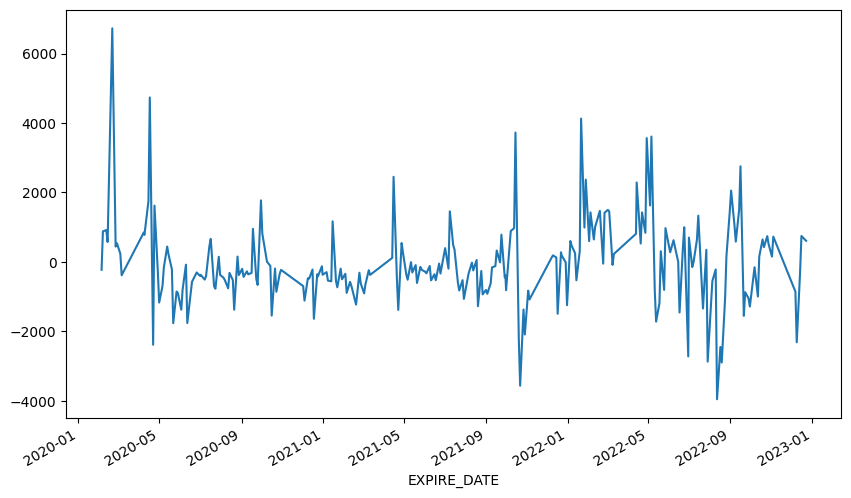

Plotting daily Profit/Loss of JR model


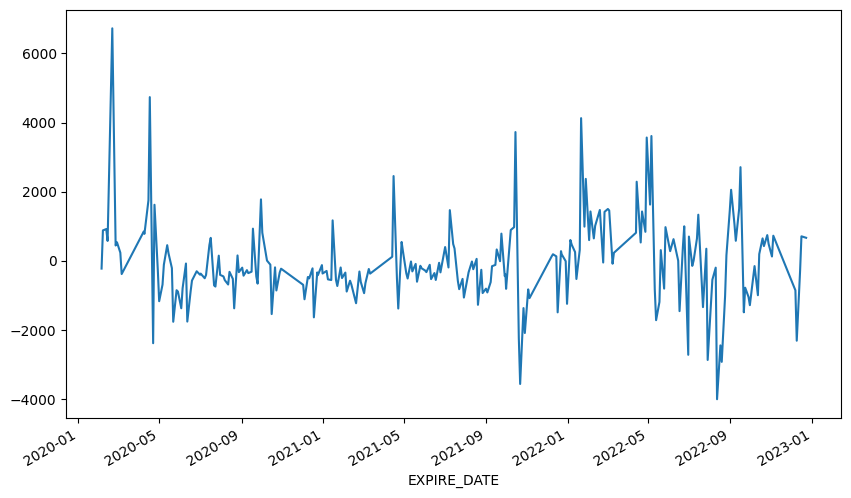

Plotting total Profit/Loss of CRR model


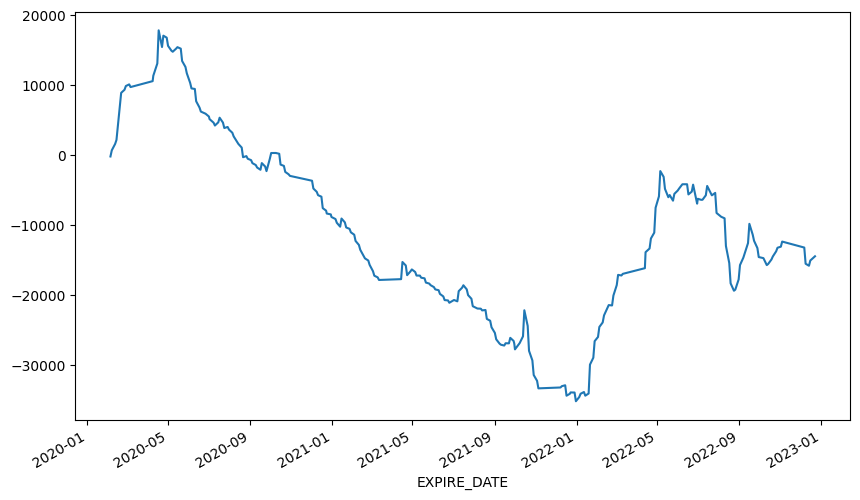

Plotting total Profit/Loss of JR model


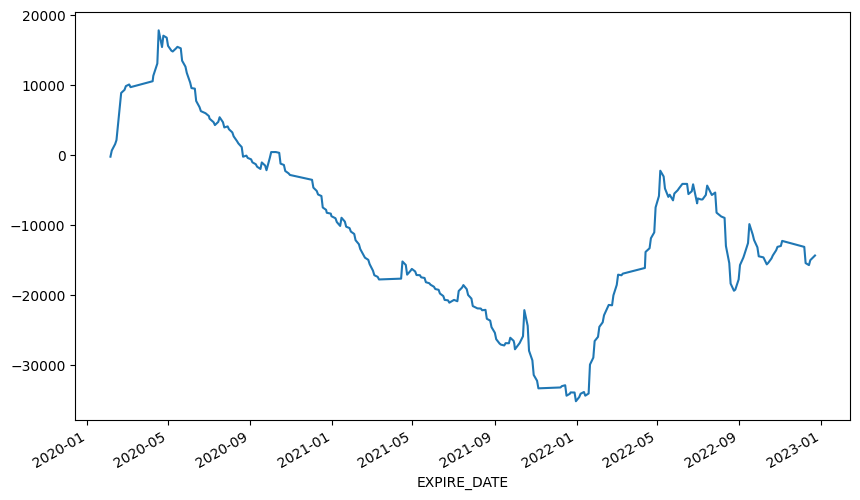

In [144]:
print('Mean Profit/Loss of CRR model:',np.mean(df_binomial_model_crr['PROFIT_LOSS']))
print('Mean Profit/Loss of JR model:',np.mean(df_binomial_model_jr['PROFIT_LOSS']))
print('Volatility of CRR model:',np.std(df_binomial_model_crr['PROFIT_LOSS']))
print('Volatility of JR model:',np.std(df_binomial_model_jr['PROFIT_LOSS']))
print('Total Profit/Loss of CRR model:',np.sum(df_binomial_model_crr['PROFIT_LOSS']))
print('Total Profit/Loss of JR model:',np.sum(df_binomial_model_jr['PROFIT_LOSS']))

df_total_profit_loss_crr = df_binomial_model_crr['PROFIT_LOSS'].sum()
df_total_profit_loss_jr = df_binomial_model_jr['PROFIT_LOSS'].sum()

print('Plotting daily Profit/Loss of CRR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.show()

print('Plotting daily Profit/Loss of JR model')
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.show()

print('Plotting total Profit/Loss of CRR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.show()

print('Plotting total Profit/Loss of JR model')
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.show()

Plotting Profit/Loss of Long and Short of Call and Put of CRR model
Inverting y axis


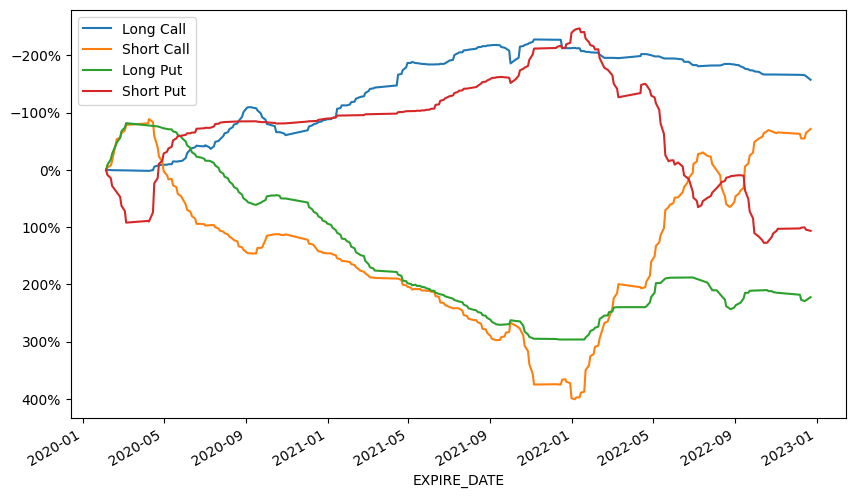

Plotting Profit/Loss of Long and Short of Call and Put of JR model
Inverting y axis


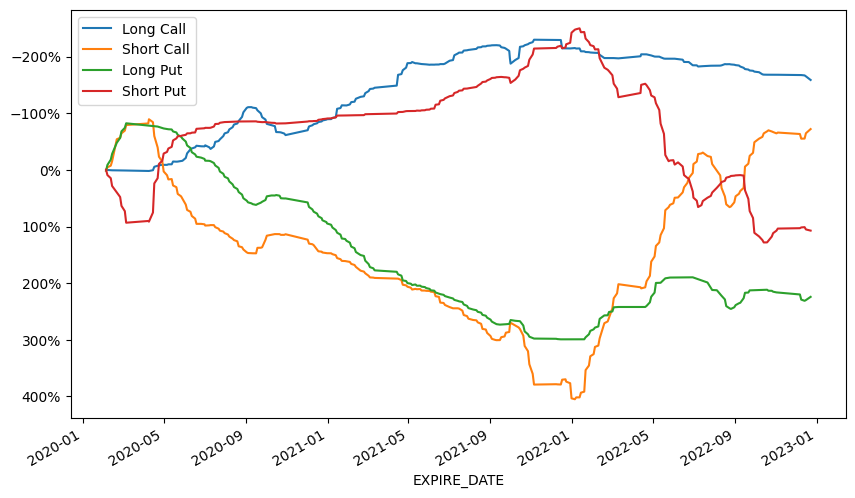

In [145]:
# plot profit/loss of long and short of call and put for crr model
print('Plotting Profit/Loss of Long and Short of Call and Put of CRR model')
df_long_call_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_CALL'] == 1]
df_short_call_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_CALL'] == -1]
df_long_put_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_PUT'] == 1]
df_short_put_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_PUT'] == -1]
(df_long_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/df_total_profit_loss_crr).plot(label='Long Call')
(df_short_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/df_total_profit_loss_crr).plot(label='Short Call')
(df_long_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/df_total_profit_loss_crr).plot(label='Long Put')
(df_short_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/df_total_profit_loss_crr).plot(label='Short Put')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
if df_total_profit_loss_crr < 0:
    print('Inverting y axis')
    plt.gca().invert_yaxis()
plt.legend()
plt.show()

# plot profit/loss of long and short of call and put for jr model
print('Plotting Profit/Loss of Long and Short of Call and Put of JR model')
df_long_call_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_CALL'] == 1]
df_short_call_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_CALL'] == -1]
df_long_put_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_PUT'] == 1]
df_short_put_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_PUT'] == -1]
(df_long_call_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/df_total_profit_loss_jr).plot(label='Long Call')
(df_short_call_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/df_total_profit_loss_jr).plot(label='Short Call')
(df_long_put_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/df_total_profit_loss_jr).plot(label='Long Put')
(df_short_put_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/df_total_profit_loss_jr).plot(label='Short Put')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
if df_total_profit_loss_jr < 0:
    print('Inverting y axis')
    plt.gca().invert_yaxis()
plt.legend()
plt.show()


Plotting Profit/Loss of Call and Put of CRR model
Inverting y axis


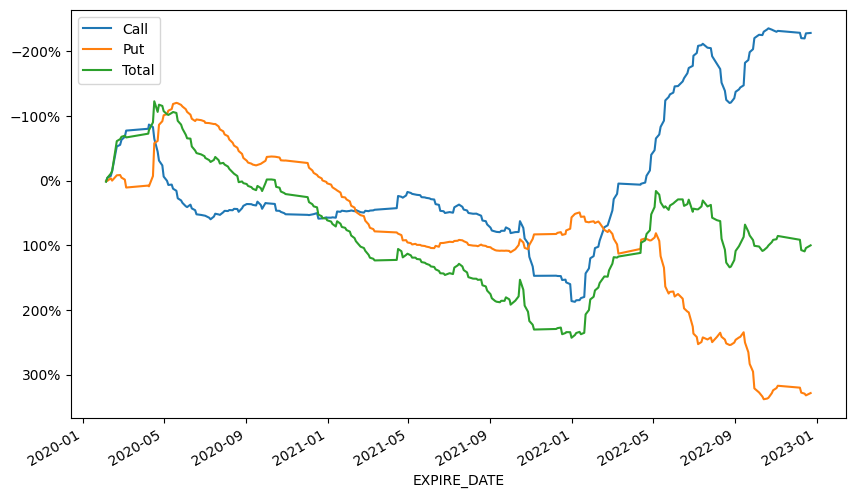

Plotting Profit/Loss of Call and Put of JR model
Inverting y axis


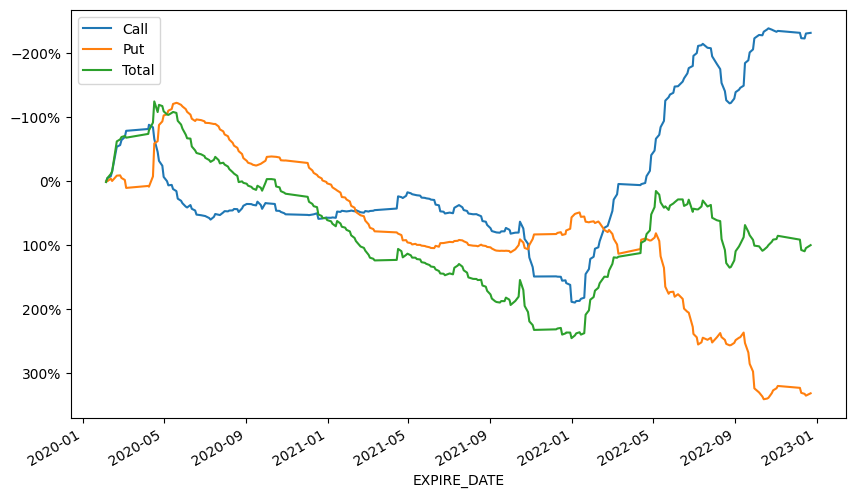

In [146]:
# plot profit/loss of call and put for crr model
print('Plotting Profit/Loss of Call and Put of CRR model')
(df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()/df_total_profit_loss_crr).plot()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# if the total profit/loss is negative, invert the y axis
if df_total_profit_loss_crr < 0:
    print('Inverting y axis')
    plt.gca().invert_yaxis()
plt.legend(['Call','Put','Total'])
plt.show()

# plot profit/loss of call and put for jr model
print('Plotting Profit/Loss of Call and Put of JR model')
(df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()/df_total_profit_loss_jr).plot() 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# if the total profit/loss is negative, invert the y axis
if df_total_profit_loss_jr < 0:
    print('Inverting y axis')
    plt.gca().invert_yaxis()
plt.legend(['Call','Put','Total'])
plt.show()

# Limiting devitation to 10%

In [147]:
df_binomial_model_crr = calculate_profit(df_binomial_model_crr, long_call=True, short_call=True, long_put=True, short_put=True, deviation=0.1)

df_binomial_model_jr = calculate_profit(df_binomial_model_jr, long_call=True, short_call=True, long_put=True, short_put=True, deviation=0.1)

Mean Profit/Loss of CRR model: 0.2437407849469913
Mean Profit/Loss of JR model: 0.25121621147230183
Volatility of CRR model: 19.076043535318924
Volatility of JR model: 19.080055467270356
Total Profit/Loss of CRR model: 6943.199999999994
Total Profit/Loss of JR model: 7156.14499999999
Plotting daily Profit/Loss of CRR model


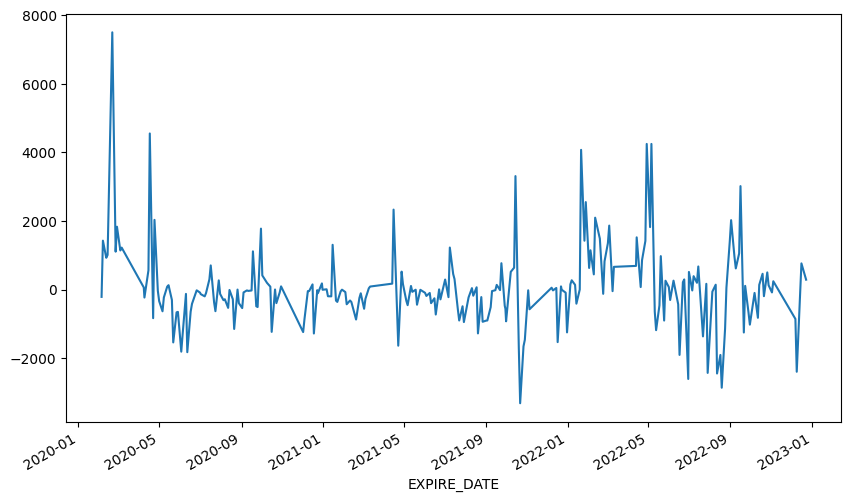

Plotting daily Profit/Loss of JR model


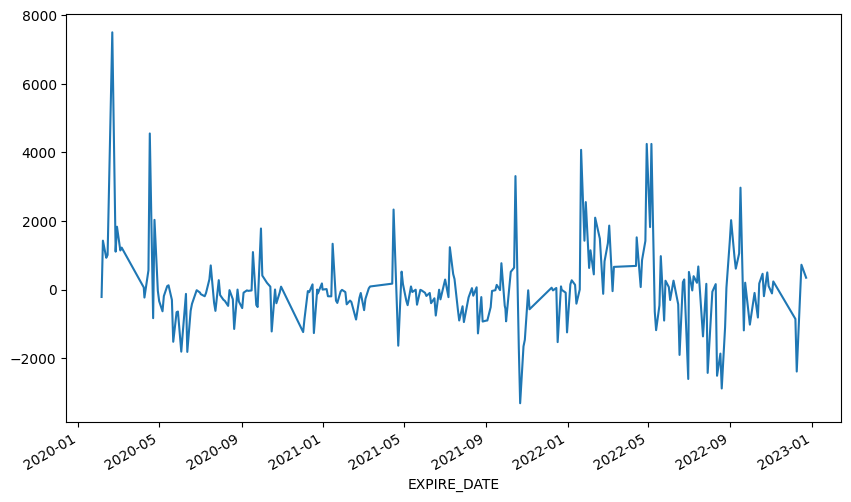

Plotting total Profit/Loss of CRR model


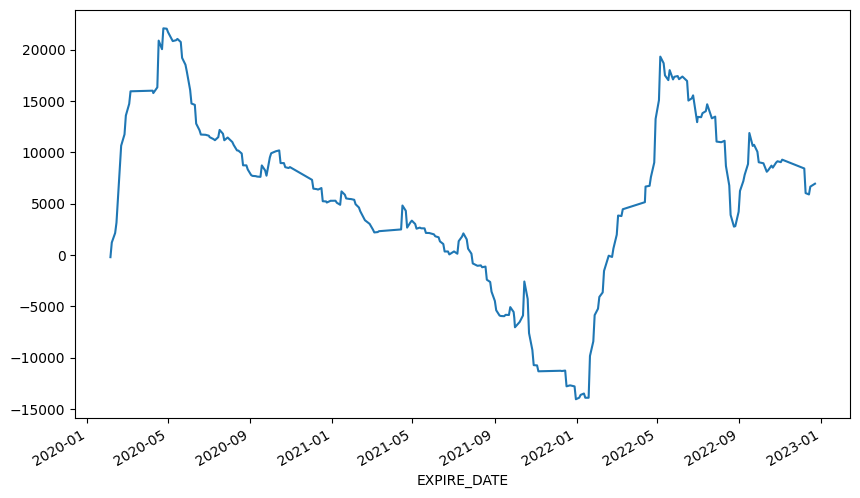

Plotting total Profit/Loss of JR model


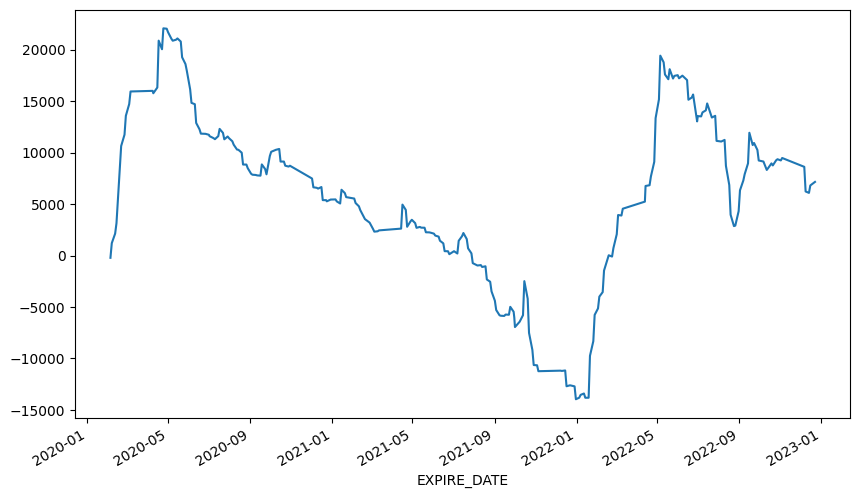

In [148]:
print('Mean Profit/Loss of CRR model:',np.mean(df_binomial_model_crr['PROFIT_LOSS']))
print('Mean Profit/Loss of JR model:',np.mean(df_binomial_model_jr['PROFIT_LOSS']))
print('Volatility of CRR model:',np.std(df_binomial_model_crr['PROFIT_LOSS']))
print('Volatility of JR model:',np.std(df_binomial_model_jr['PROFIT_LOSS']))
print('Total Profit/Loss of CRR model:',np.sum(df_binomial_model_crr['PROFIT_LOSS']))
print('Total Profit/Loss of JR model:',np.sum(df_binomial_model_jr['PROFIT_LOSS']))

df_total_profit_loss_crr = df_binomial_model_crr['PROFIT_LOSS'].sum()
df_total_profit_loss_jr = df_binomial_model_jr['PROFIT_LOSS'].sum()

print('Plotting daily Profit/Loss of CRR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.show()

print('Plotting daily Profit/Loss of JR model')
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().plot()
plt.show()

print('Plotting total Profit/Loss of CRR model')
df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.show()

print('Plotting total Profit/Loss of JR model')
df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS'].sum().cumsum().plot()
plt.show()

Plotting Profit/Loss of Long and Short of Call and Put of CRR model


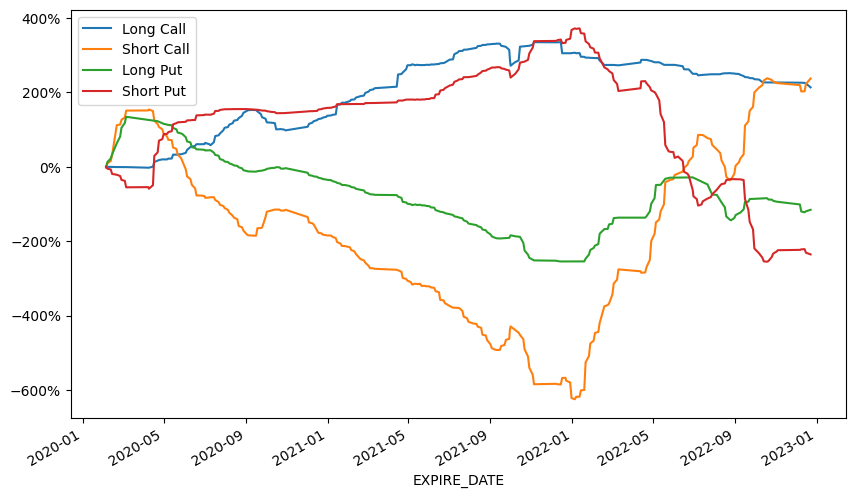

Plotting Profit/Loss of Long and Short of Call and Put of JR model


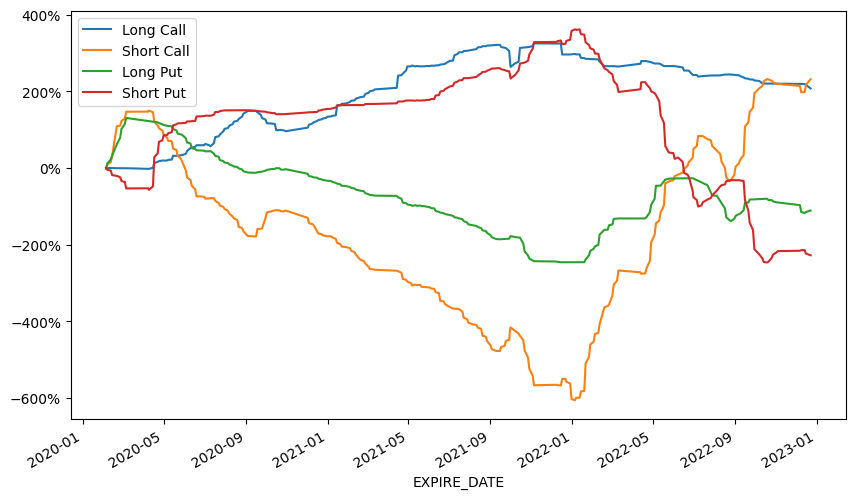

In [149]:
# plot profit/loss of long and short of call and put for crr model
print('Plotting Profit/Loss of Long and Short of Call and Put of CRR model')
df_long_call_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_CALL'] == 1]
df_short_call_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_CALL'] == -1]
df_long_put_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_PUT'] == 1]
df_short_put_crr = df_binomial_model_crr[df_binomial_model_crr['LONG_PUT'] == -1]
(df_long_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/df_total_profit_loss_crr).plot(label='Long Call')
(df_short_call_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/df_total_profit_loss_crr).plot(label='Short Call')
(df_long_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/df_total_profit_loss_crr).plot(label='Long Put')
(df_short_put_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/df_total_profit_loss_crr).plot(label='Short Put')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
if df_total_profit_loss_crr < 0:
    print('Inverting y axis')
    plt.gca().invert_yaxis()
plt.legend()
plt.show()

# plot profit/loss of long and short of call and put for jr model
print('Plotting Profit/Loss of Long and Short of Call and Put of JR model')
df_long_call_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_CALL'] == 1]
df_short_call_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_CALL'] == -1]
df_long_put_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_PUT'] == 1]
df_short_put_jr = df_binomial_model_jr[df_binomial_model_jr['LONG_PUT'] == -1]
(df_long_call_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/df_total_profit_loss_jr).plot(label='Long Call')
(df_short_call_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL'].sum().cumsum()/df_total_profit_loss_jr).plot(label='Short Call')
(df_long_put_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/df_total_profit_loss_jr).plot(label='Long Put')
(df_short_put_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_PUT'].sum().cumsum()/df_total_profit_loss_jr).plot(label='Short Put')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
if df_total_profit_loss_jr < 0:
    print('Inverting y axis')
    plt.gca().invert_yaxis()
plt.legend()
plt.show()


Plotting Profit/Loss of Call and Put of CRR model


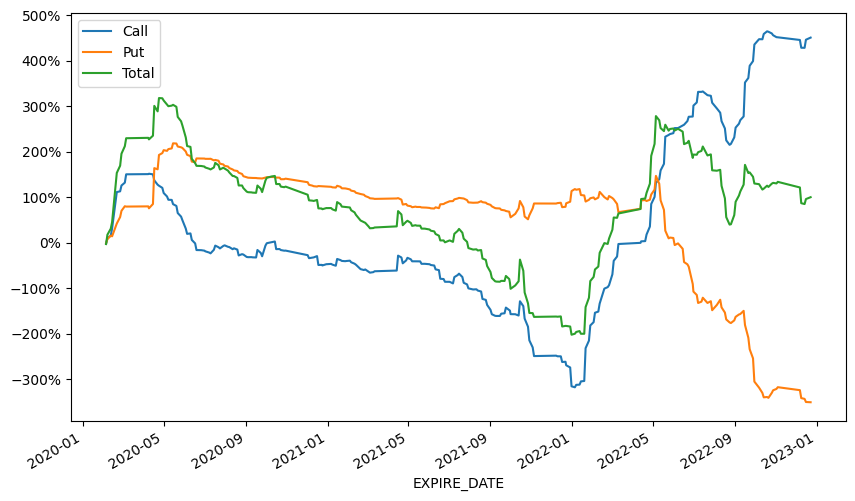

Plotting Profit/Loss of Call and Put of JR model


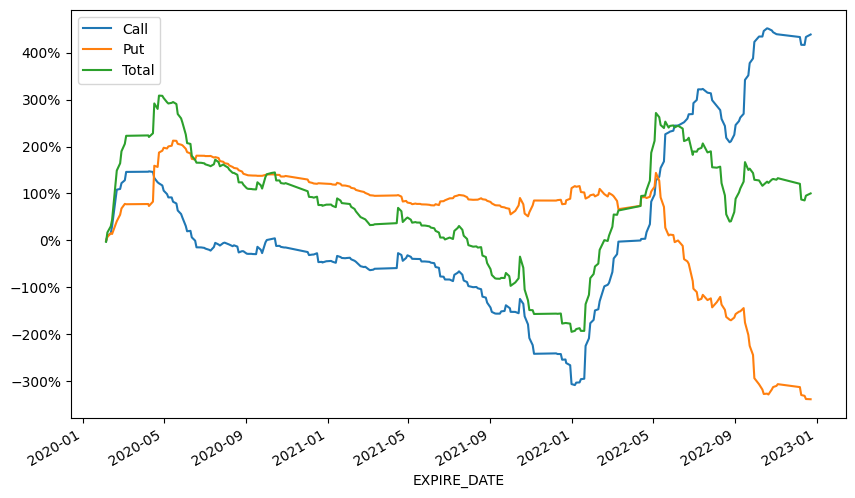

In [150]:
# plot profit/loss of call and put for crr model
print('Plotting Profit/Loss of Call and Put of CRR model')
(df_binomial_model_crr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()/df_total_profit_loss_crr).plot()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
if df_total_profit_loss_crr < 0:
    print('Inverting y axis')
    plt.gca().invert_yaxis()
plt.legend(['Call','Put','Total'])
plt.show()

# plot profit/loss of call and put for jr model
print('Plotting Profit/Loss of Call and Put of JR model')
(df_binomial_model_jr.groupby('EXPIRE_DATE')['PROFIT_LOSS_CALL','PROFIT_LOSS_PUT','PROFIT_LOSS'].sum().cumsum()/df_total_profit_loss_jr).plot() 
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
if df_total_profit_loss_jr < 0:
    print('Inverting y axis')
    plt.gca().invert_yaxis()
plt.legend(['Call','Put','Total'])
plt.show()